In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle

from Configs import getEnvConfig, visualizeEnvConfig, getPredictorConfig, visualizePredictorConfig
from EnvLibs import PolicyDemoAdaptiveAlpha, PolicySimulator, createEnv
from MdpSolverLibs import MdpKernel

In [2]:
configIdx = 0
envParams = getEnvConfig(configIdx)
visualizeEnvConfig(envParams)
predictorParams = getPredictorConfig(configIdx)
visualizePredictorConfig(predictorParams)
trafficDataParentPath = f'Results/TrafficData'
env = createEnv(envParams, trafficDataParentPath)
env.selectMode(mode="test", type="data")

Environment Configuration
Number of Users:        4
Window Length:          200
Dataflow:               thumb_fr
N_aggregation:          4
Resource Bar:           5
Bandwidth:              100
M List:                 [3, 4, 5]
Random Seed:            999
Alpha Range:            (0.01, 1.0)
Discrete Alpha Steps:   10
Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


(100, 4)
(100, 4)


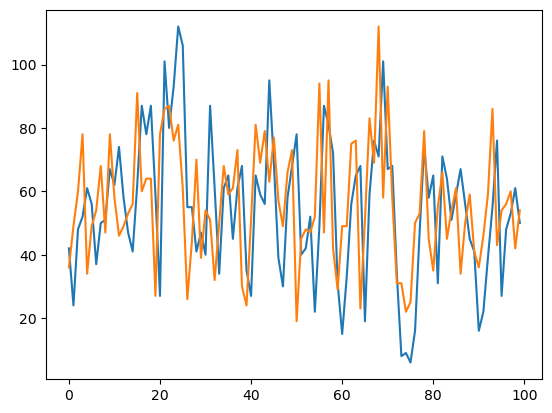

In [3]:
env.reset()
env.selectMode(mode="test", type="data")
u_record = []
u_predicted_record = []
for _ in range(100):
    env.updateStates()
    u, u_predicted = env.getStates()
    u_record.append(u)
    u_predicted_record.append(u_predicted)

u_record = np.array(u_record)
u_predicted_record = np.array(u_predicted_record)
print(u_record.shape)
print(u_predicted_record.shape)
plt.plot(u_record[:,0].flatten())
plt.plot(u_predicted_record[:,0].flatten())
plt.show()

In [ ]:
# ==== Prepare Policy====
with open(f'Results/MdpPolicy/mdpKernelParams_config{configIdx}.pkl', 'rb') as f:
    mdpKernelParams = pickle.load(f)
mdpPolicy = MdpKernel()
mdpPolicy.load_policy(mdpKernelParams)
adaptiveAlphaPolicy = PolicyDemoAdaptiveAlpha(envParams)

# ==== Prepare Simulator====
num_windows = 2000
obvMode = "predicted" # "perfect" or "predicted"
policySimulator = PolicySimulator(mdpPolicy, env)
simResultMdp = policySimulator.runSimulation(mdpPolicy, num_windows=num_windows, obvMode=obvMode, mode="test", type="data")
simResultAdaptive = policySimulator.runSimulation(adaptiveAlphaPolicy, num_windows=num_windows, obvMode=obvMode, mode="test", type="data")

print(f"avg_reward_mdp: {np.mean(simResultMdp['rewardRecord'])}, avg_reward_adaptive: {np.mean(simResultAdaptive['rewardRecord'])}")

plt.plot(simResultAdaptive['rewardRecord'], label="adaptive")
plt.plot(simResultMdp['rewardRecord'], label="mdp")
plt.legend()
plt.show()